## This Time series analysis is carried out on avg. temperature datapoints of Delhi city to predict the temperature in future

## 1.Importing required libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**1.1 importing dataset and creating the dataframe**

Setting the date column as index for dataset

In [2]:
df = pd.read_csv('datasets_312121_636393_DailyDelhiClimateTrain.csv',index_col='date',parse_dates=True)

In [3]:
df.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## 2. Data cleaning and visualization

**2.1 This analysis specifically focuses on temperature prediction therefore dropping all other variables**

In [4]:
df.drop(['humidity','wind_speed','meanpressure'],axis=1,inplace=True)
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000




**2.2 Observing data for any Null value**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meantemp  1462 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


In dataset there are 1462 observations and 0 null values

**2.3. Now obesrving any outliers within dataset** 

(array([  5.,   4.,  15.,  50.,  61.,  65.,  83.,  91.,  55.,  52.,  82.,
         81.,  65., 110., 168., 214., 118.,  71.,  44.,  28.]),
 array([ 6.        ,  7.63571429,  9.27142857, 10.90714286, 12.54285714,
        14.17857143, 15.81428571, 17.45      , 19.08571429, 20.72142857,
        22.35714286, 23.99285714, 25.62857143, 27.26428571, 28.9       ,
        30.53571429, 32.17142857, 33.80714286, 35.44285714, 37.07857143,
        38.71428571]),
 <BarContainer object of 20 artists>)

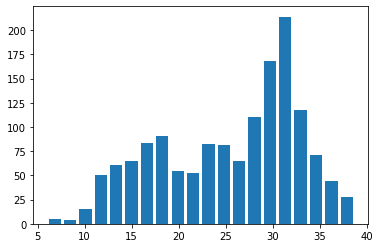

In [6]:
plt.hist(df.meantemp,bins=20, rwidth=0.8)

In [7]:
df.meantemp.describe()

count    1462.000000
mean       25.495521
std         7.348103
min         6.000000
25%        18.857143
50%        27.714286
75%        31.305804
max        38.714286
Name: meantemp, dtype: float64

**2.4 Visualize the dataponts**

<AxesSubplot:xlabel='date'>

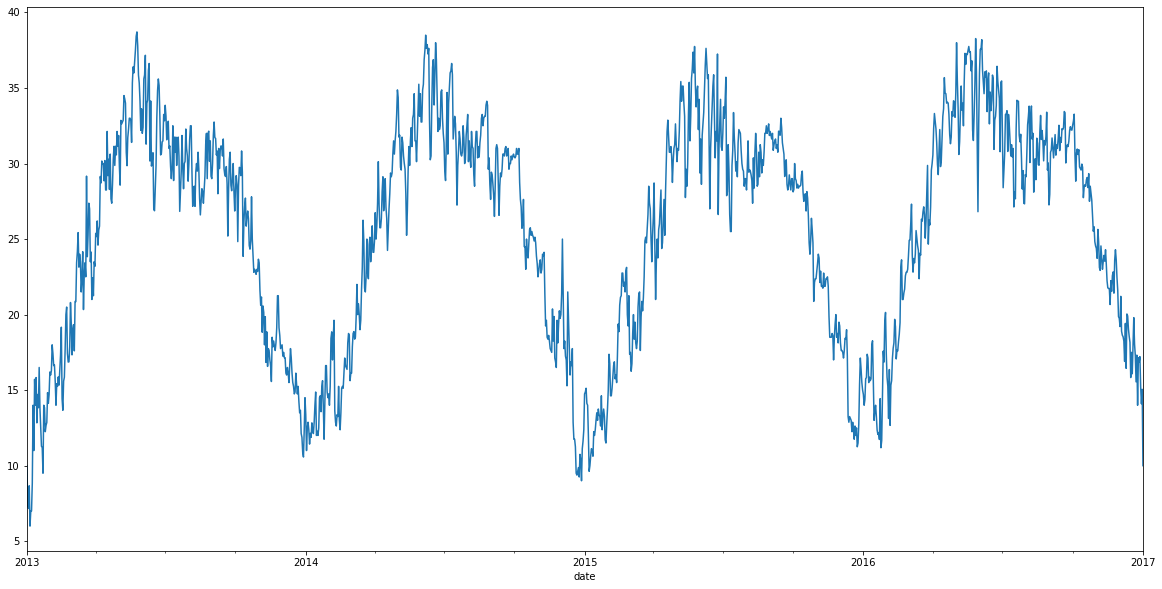

In [8]:
df.meantemp.plot(figsize=(20,10))

**2.5 Resampling to Monthly Dataset**

In [19]:
monthlytemp = df.resample('M').mean()
monthlytemp.head()

,meantemp
date,
2013-01-31,12.074770
2013-02-28,16.867560
2013-03-31,22.814209
2013-04-30,28.895119
2013-05-31,33.776767


**2.6 Visualizing monthly temperature dataset**

<AxesSubplot:xlabel='date'>

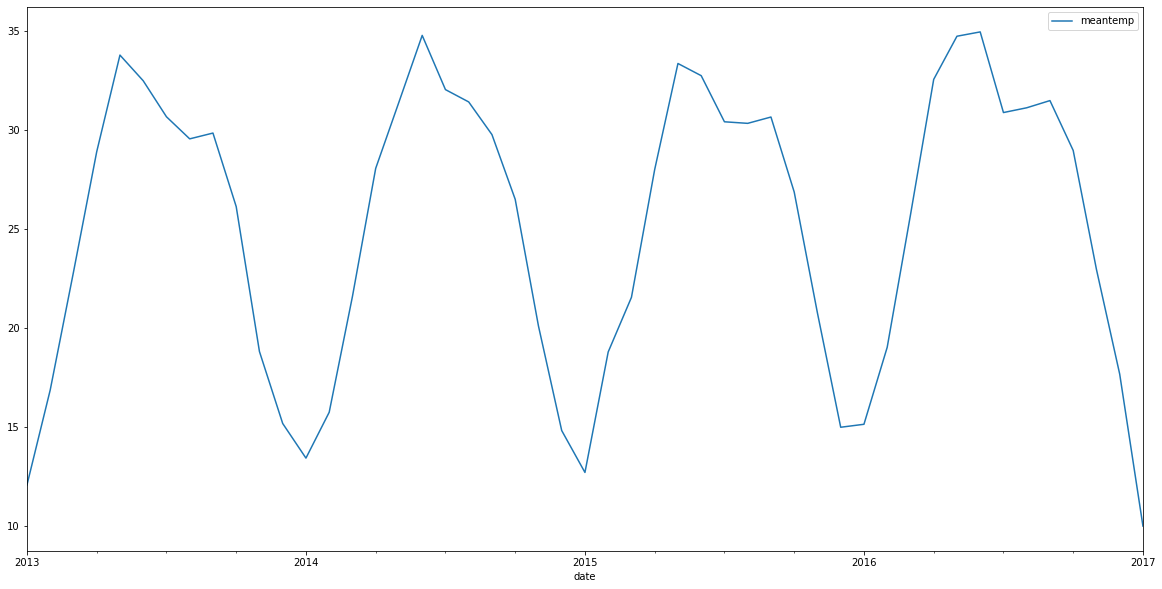

In [18]:
monthlytemp.plot(figsize=(20,10))

Data shows the seasonality as there are ups and downs in the value for particular time interval

**2.7 Testing for Stationarity by using Statistical method - Augmented dickey-fuller test**

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
def adfuller_test(meantemp):
    result=adfuller(meantemp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [22]:
adfuller_test(monthlytemp['meantemp'])

ADF Test Statistic : -1.0462204206798995
p-value : 0.7360356050589126
#Lags Used : 10
Number of Observations Used : 38
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**From the adfuller test it is clear that, Data is non stationary**

**2.8 Making data stationary**

Taking difference with lag of 1

In [35]:
monthlytemp['first_difference'] = monthlytemp.meantemp-monthlytemp.meantemp.shift(1)
monthlytemp.head()

,meantemp,first_difference
date,,
2013-01-31,12.074770,NaN
2013-02-28,16.867560,4.792790
2013-03-31,22.814209,5.946649
2013-04-30,28.895119,6.080910
2013-05-31,33.776767,4.881647


In [25]:
adfuller_test(monthlytemp['first_difference'].dropna())

ADF Test Statistic : -7.275868440106254
p-value : 1.545072980597148e-10
#Lags Used : 9
Number of Observations Used : 38
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='date'>

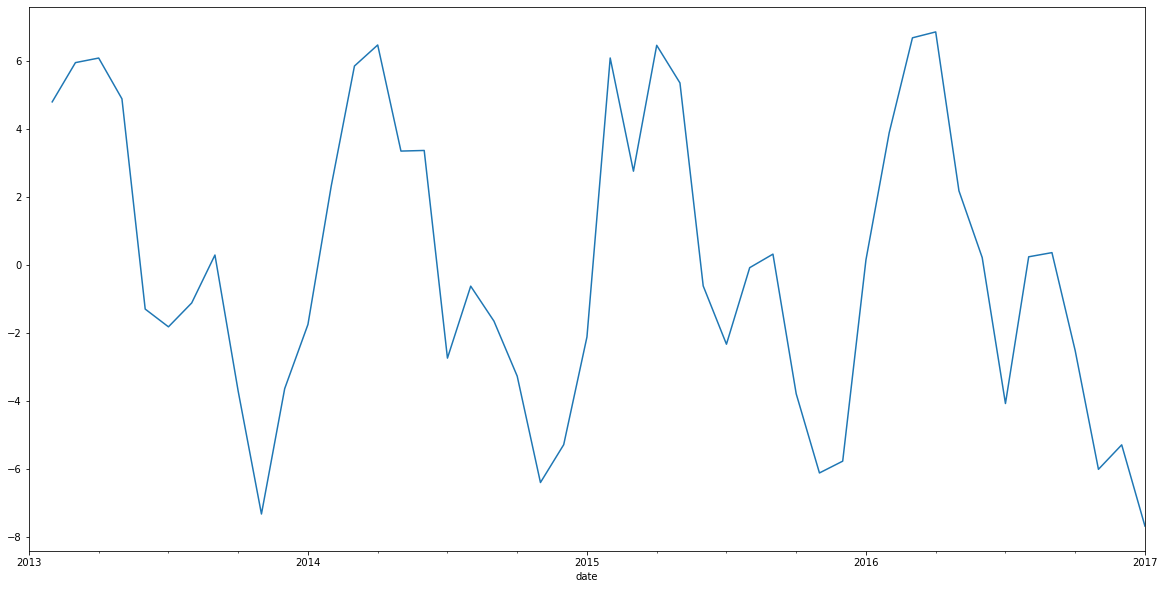

In [26]:
monthlytemp.first_difference.plot(figsize=(20,10))

**2.9 Now Plot Partial Autocorrelation and Autocorrelation plot to find the vaues of p,d and q**

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


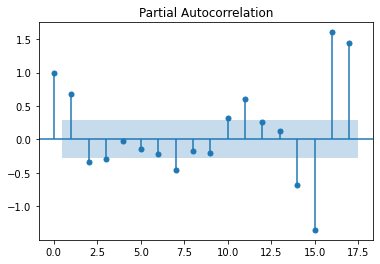

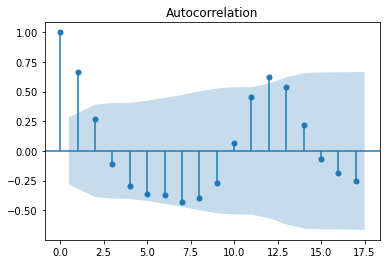

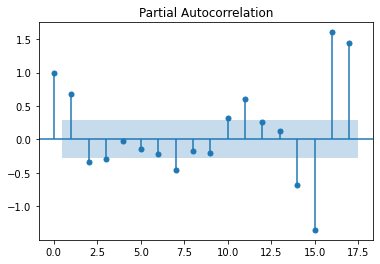

In [30]:
plot_acf(monthlytemp['first_difference'].dropna())

plot_pacf(monthlytemp['first_difference'].dropna())

From the above graph we observe exponential decrease in Autocorilation value and it comes within range at 2 thus q=2
from Partial Autocorrelation ghraph we can say that p = 3
Therefor final order is p=3, d=1,q=2

**2.10 Similarly we can find the model and p,d,q values Atomatically usin AutoARIMA**

In [85]:
from pmdarima import auto_arima 

In [86]:
auto_arima(monthlytemp['meantemp'], seasonal=True,start_p=0,start_q=0,max_order=4,test='adf',error_action='ignore',stepwise= True,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=336.992, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=285.488, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=295.017, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=461.037, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=235.461, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=236.921, Time=0.71 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=234.108, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=262.483, Time=0.27 sec


c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=230.899, Time=1.40 sec


c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=231.667, Time=1.50 sec


c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=238.054, Time=1.32 sec


c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=231.045, Time=1.44 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=238.350, Time=0.60 sec


c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=242.942, Time=1.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.09 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 11.358 seconds


c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -109.449
Date:                Tue, 18 Aug 2020   AIC                            230.899
Time:                        17:33:58   BIC                            242.250
Sample:                             0   HQIC                           235.205
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3766      1.896      1.781      0.075      -0.339       7.092
ar.L1          2.1539      0.219      9.850      0.000       1.725       2.582
ar.L2         -1.7477      0.357     -4.901      0.000      -2.447      -1.049
ar.L3          0.4600      0.209      2.201      0.028       0.050       0.870
ma.L1         -0.9693      0.213     -4.543      0.000      -1.387      -0.551
sigma2         4.6375      1.406      3.297      0.001       1.881       7.394
===================================================================================
Ljung-Box (Q):                       55.83   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.05   Prob(JB):                         0.76
Heteroskedasticity (H):               1.64   Skew:                             0.16
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AutoARIMA shows that we should use SARIMAX WITH p=3,d=0,q=1

## 3. Training the Model

**3.1 Splitting dataset into train and test dataset**

In [31]:
monthlytemp.shape

(49, 2)

In [36]:
traindata= monthlytemp[0:30]
testdata= monthlytemp[31:]

In [87]:
traindata.head()


,meantemp,first_difference
date,,
2013-01-31,12.074770,NaN
2013-02-28,16.867560,4.792790
2013-03-31,22.814209,5.946649
2013-04-30,28.895119,6.080910
2013-05-31,33.776767,4.881647


In [38]:
testdata.head()

,meantemp,first_difference
date,,
2015-08-31,30.330789,-0.078773
2015-09-30,30.650000,0.319211
2015-10-31,26.865207,-3.784793
2015-11-30,20.754167,-6.111041
2015-12-31,14.989631,-5.764535


**3.2 Training the model using Seasonal Arima model(SARIMAX)**

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [94]:
model = SARIMAX(traindata.meantemp,order=(3,1,2), seasonal_order=(3,1,2,12), m=12)
results = model.fit()
results.summary()

c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           meantemp   No. Observations:                   30
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                 -30.148
Date:                            Tue, 18 Aug 2020   AIC                             82.295
Time:                                    17:40:21   BIC                             91.461
Sample:                                01-31-2013   HQIC                            83.206
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4727      7.407     -0.064      0.949     -14.991      14.046
ar.L2         -0.0240      3.584     -0.007      0.995      -7.048       7.000
ar.L3          0.0900      1.827      0.049      0.961      -3.492       3.672
ma.L1         -0.4528   1603.254     -0.000      1.000   -3142.773    3141.867
ma.L2         -0.5468    874.436     -0.001      1.000   -1714.410    1713.316
ar.S.L12      -0.3910    1.6e+06  -2.44e-07      1.000   -3.14e+06    3.14e+06
ar.S.L24       0.0684   3.49e+05   1.96e-07      1.000   -6.84e+05    6.84e+05
ar.S.L36       0.3971   1.27e+06   3.12e-07      1.000    -2.5e+06     2.5e+06
ma.S.L12      -0.7445   2.79e+06  -2.67e-07      1.000   -5.47e+06    5.47e+06
ma.S.L24       0.2657   1.42e+06   1.87e-07      1.000   -2.79e+06    2.79e+06
sigma2         0.6039   7.45e+05    8.1e-07      1.000   -1.46e+06    1.46e+06
===================================================================================
Ljung-Box (Q):                       10.45   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.84   Prob(JB):                         0.50
Heteroskedasticity (H):               0.68   Skew:                             0.63
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.94e+14. Standard errors may be unstable.
"""

## 4.Prediction and Evaluation

**4.1 Predicting the future values**

In [95]:
start=len(traindata)+1
end=len(traindata)+len(testdata)
predictions = results.predict(start=start, end=end).rename('SARIMAX Predictions')
predictions

2015-08-31    30.335528
2015-09-30    29.944129
2015-10-31    26.463933
2015-11-30    19.306400
2015-12-31    15.361800
2016-01-31    12.973843
2016-02-29    16.378298
2016-03-31    22.683572
2016-04-30    28.905298
2016-05-31    32.971884
2016-06-30    33.884870
2016-07-31    31.569869
2016-08-31    30.675110
2016-09-30    30.097248
2016-10-31    26.576425
2016-11-30    19.698460
2016-12-31    15.284462
2017-01-31    13.464750
Freq: M, Name: SARIMAX Predictions, dtype: float64

In [96]:
testdata['Predicted_value']=predictions
testdata

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,meantemp,first_difference,Predicted_value
date,,,
2015-08-31,30.330789,-0.078773,30.335528
2015-09-30,30.650000,0.319211,29.944129
2015-10-31,26.865207,-3.784793,26.463933
2015-11-30,20.754167,-6.111041,19.306400
2015-12-31,14.989631,-5.764535,15.361800
2016-01-31,15.139363,0.149731,12.973843
2016-02-29,19.025676,3.886314,16.378298
2016-03-31,25.701075,6.675399,22.683572
2016-04-30,32.550029,6.848954,28.905298


**4.2 Visualizing the Testdata values with predicted values**

<AxesSubplot:xlabel='date'>

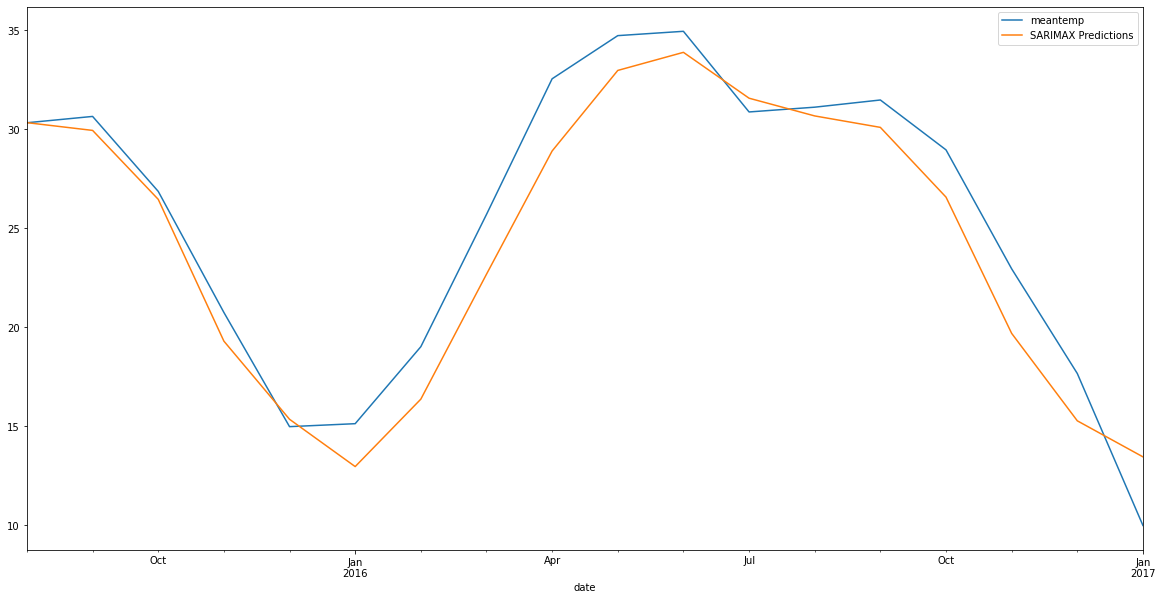

In [97]:
testdata.meantemp.plot(legend= True,figsize=(20,10))
predictions.plot(legend= True)

**4.3 Calcuting error value between actual testdata set and predicted value**

In [101]:
from statsmodels.tools.eval_measures import rmse
error = rmse(testdata.meantemp,predictions)
print('Root Mean Squared Error ',error)

Root Mean Squared Error  2.079009862512651


## 5.Forcasting values for next year

**5.1 Predicting the future values using SARIMAX**

In [102]:
model = SARIMAX(monthlytemp.meantemp,order=(3,1,2), seasonal_order=(3,1,2,12), m=12)
results = model.fit()
fcast = results.predict(len(monthlytemp)-1,len(monthlytemp)+11,typ='levels').rename('SARIMA Future Forecast')

c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
c:\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [103]:
fcast

2017-01-31    14.651288
2017-02-28    16.148677
2017-03-31    22.064643
2017-04-30    29.478006
2017-05-31    33.929824
2017-06-30    35.002352
2017-07-31    32.407183
2017-08-31    32.134877
2017-09-30    31.278956
2017-10-31    27.883704
2017-11-30    21.127915
2017-12-31    16.177745
2018-01-31    15.648323
Freq: M, Name: SARIMA(2,0,2)(2,1,0,12) Forecast, dtype: float64

**5.2 Visualizing the future forecast**

<AxesSubplot:xlabel='date'>

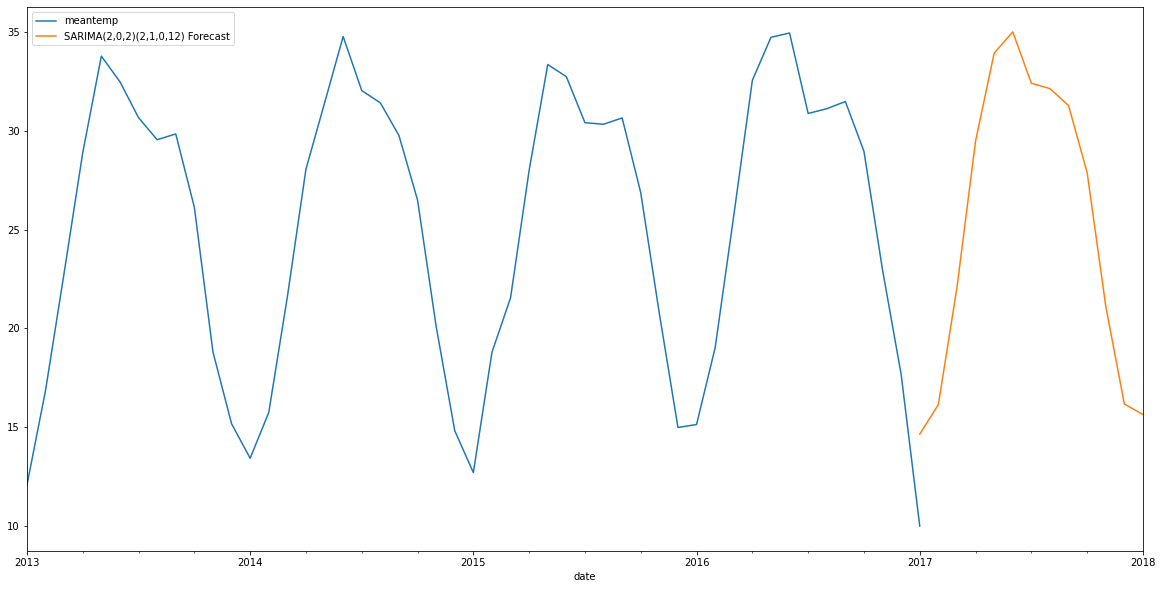

In [104]:
monthlytemp.meantemp.plot(legend=True, figsize=(20,10))
fcast.plot(legend=True)